# ANN to Predict Subject
Using modal representation, can we tell which subject it came from?

If so, perhaps there is structure here.

Setup: Javascript and ipynb stuff

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

## Load Functions

In [53]:
from fastai.vision import *
import os
import numpy as np
import pandas as pd
import pickle
import warnings; warnings.simplefilter('ignore')

In [4]:
path=pathlib.Path('/home/tris/Documents/EEG_data/DMD_DEAP')
path

PosixPath('/home/tris/Documents/EEG_data/DMD_DEAP')

## Load Original Data Labels

In [7]:
path = '/media/tris/tris_files/EEG_datasets/DEAP_data_preprocessed_python/s01.dat'
df_read = pickle.load(open(path, 'rb'), encoding='latin1')
labels=df_read['labels']
df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
df=df_tmp
for n in range (2,10):
    path = '/media/tris/tris_files/EEG_datasets/DEAP_data_preprocessed_python/s0'+str(n)+'.dat'
    df_read = pickle.load(open(path, 'rb'), encoding='latin1')
    labels=df_read['labels']
    df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
    df=df.append(df_tmp, ignore_index=True)
for n in range (10,33):
    path = '/media/tris/tris_files/EEG_datasets/DEAP_data_preprocessed_python/s'+str(n)+'.dat'
    df_read = pickle.load(open(path, 'rb'), encoding='latin1')
    labels=df_read['labels']
    df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
    df=df.append(df_tmp, ignore_index=True) 

In [8]:
df=df.div(9) #normalize
df.head()

,valence,arousal,dominance,liking
0,0.856667,0.844444,0.766667,0.870000
1,0.900000,0.812222,0.808889,0.941111
2,0.953333,0.837778,1.000000,0.786667
3,0.548889,0.667778,0.680000,0.895556
4,0.773333,0.435556,0.798889,0.672222


## Set filenames and labels

In [9]:
df=pd.DataFrame()
filenames=[]
subject_labels=[]
for n in range (0,9):
    for i in range (0,9):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
    for i in range (9,40):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
for n in range (9,32):
    for i in range (0,9):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
    for i in range (9,40):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
df['file_name']=filenames
df['subject_label']=subject_labels
# df=df[['file_name','valence','arousal','dominance','liking']]
df=df[['file_name','subject_label']]
df.tail()

,file_name,subject_label
1275,S32T36,32
1276,S32T37,32
1277,S32T38,32
1278,S32T39,32
1279,S32T40,32


In [10]:
# for i in range(1,33):
#     for ii in range(1,41):
#         os.rename(r'/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps/T'+str(ii)+'S'+str(i)+".png",r'/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps/S'+str(i)+'T'+str(ii)+".png")

In [11]:
# from PIL import Image

# for i in range (0,1280):
    
#     im = Image.open(r"/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps/"+str(df.file_name[i])+".png")
#     im1=im.crop((0,0,1450,1030))
#     im1.save("/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps_re/"+str(df.file_name[i])+".png")

In [14]:
path=pathlib.Path('/media/tris/tris_files/EEG_datasets/robots')
path

PosixPath('/media/tris/tris_files/EEG_datasets/robots')

In [15]:
df.to_csv(path/'labels_proc.csv', index=False)

In [16]:
df = pd.read_csv(path/'labels_proc.csv') #load labels
df.tail()

,file_name,subject_label
1275,S32T36,32
1276,S32T37,32
1277,S32T38,32
1278,S32T39,32
1279,S32T40,32


## Data loader

In [17]:
src = (ImageList.from_csv(path, 'labels_proc.csv', folder='heatmaps_15', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(cols=['subject_label'],label_cls=CategoryList))

In [18]:
tfms=[]

In [19]:
data = (src.transform(tfms, size=200)
        .databunch(bs=4).normalize())

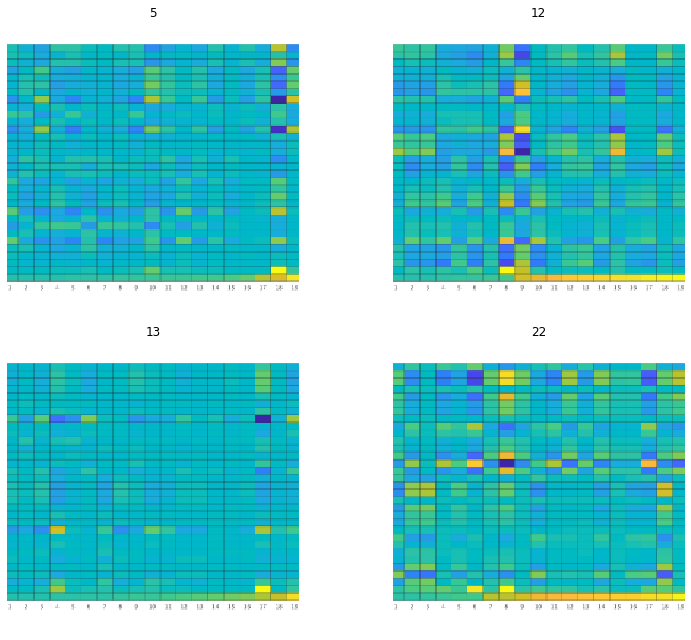

In [20]:
data.show_batch(rows=4, figsize=(12,9))

## Setup Network

In [21]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [22]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 100, 100]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 100, 100]       128        True      
______________________________________________________________________
ReLU                 [64, 100, 100]       0          False     
______________________________________________________________________
MaxPool2d            [64, 50, 50]         0          False     
______________________________________________________________________
Conv2d               [64, 50, 50]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 50, 50]         128        True      
______________________________________________________________________
ReLU                 [64, 50, 50]         0          False     
___________________________________________________

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


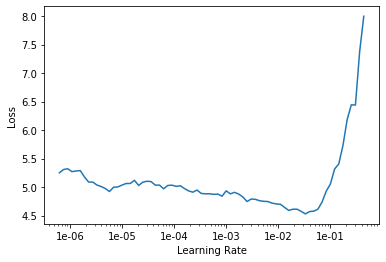

In [23]:
learn.lr_find()
learn.recorder.plot()

## Train last layers

In [24]:
lr = 1e-3
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,4.016911,2.342566,0.375000,00:14
1,2.280721,1.140539,0.675781,00:13
2,1.560562,0.810914,0.781250,00:13
3,1.133637,0.740443,0.812500,00:13
4,0.904737,0.706232,0.800781,00:14


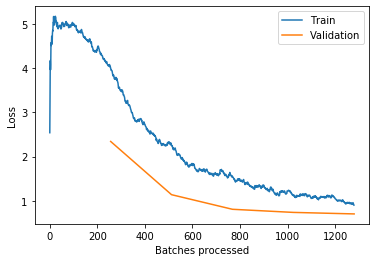

In [25]:
learn.recorder.plot_losses()

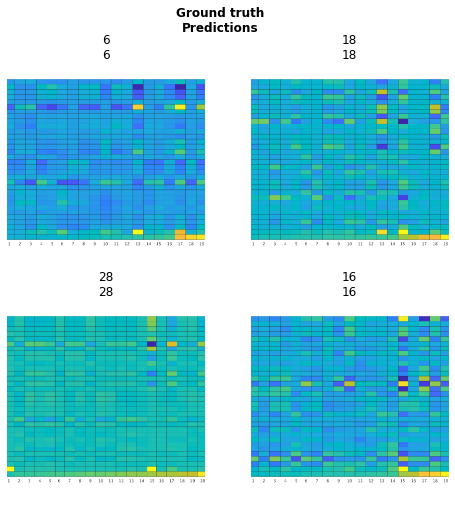

In [26]:
learn.show_results()

## Train the whole network

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


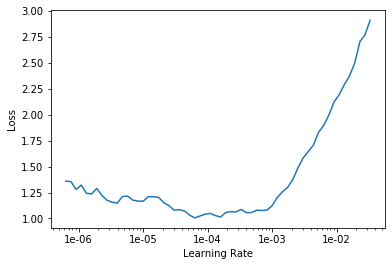

In [27]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [28]:
lr = 1e-3
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.902752,1.013439,0.703125,00:14
1,1.132951,0.487544,0.863281,00:13


In [29]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.288402,0.416446,0.863281,00:13
1,0.928653,0.142181,0.953125,00:14
2,0.588296,0.075293,0.988281,00:14


## Interpret and Results

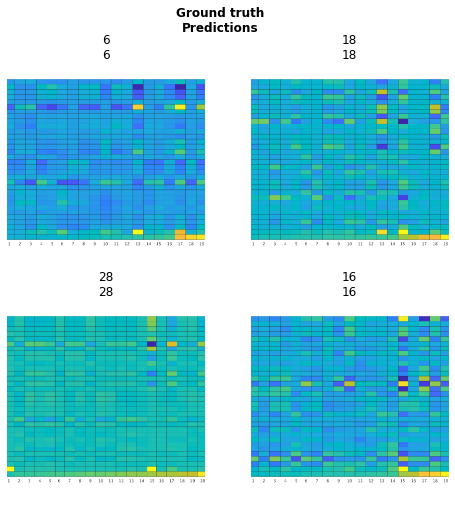

In [30]:
learn.show_results()

In [31]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [73]:
interp.confusion_matrix()

array([[17,  0,  0,  0, ...,  0,  0,  0,  0],
       [ 0, 13,  0,  0, ...,  0,  0,  0,  0],
       [ 0,  0,  8,  0, ...,  0,  0,  0,  0],
       [ 0,  0,  0,  6, ...,  0,  0,  0,  0],
       ...,
       [ 0,  0,  0,  0, ...,  7,  0,  0,  0],
       [ 0,  0,  0,  0, ...,  0,  5,  0,  0],
       [ 0,  0,  0,  0, ...,  0,  0,  7,  0],
       [ 0,  0,  0,  0, ...,  0,  0,  0,  6]])

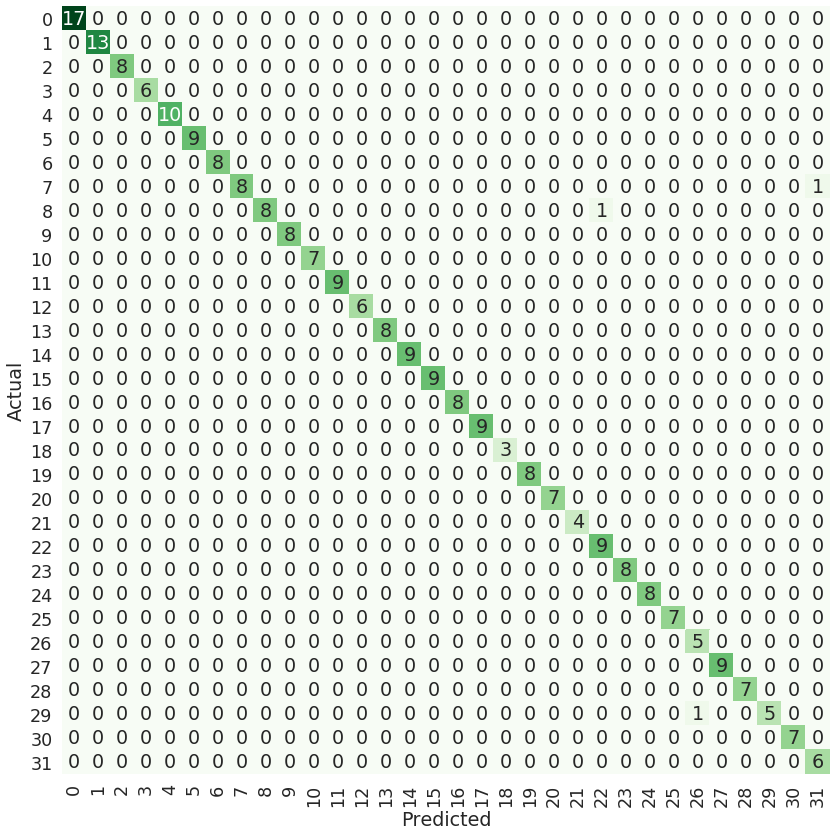

In [128]:
import seaborn as sn
array = interp.confusion_matrix()
df_cm = pd.DataFrame(array, index = [i for i in range(32)],
                  columns = [i for i in range(32)])
plt.figure(figsize = (12,12))

sn.set(font_scale=1.6)
ax=sn.heatmap(df_cm, annot=True, cbar=False, cmap='Greens')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()

In [126]:
# interp.plot_confusion_matrix(figsize=(9,9), normalize=False)
# ax = plt.subplot()
# for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(20)

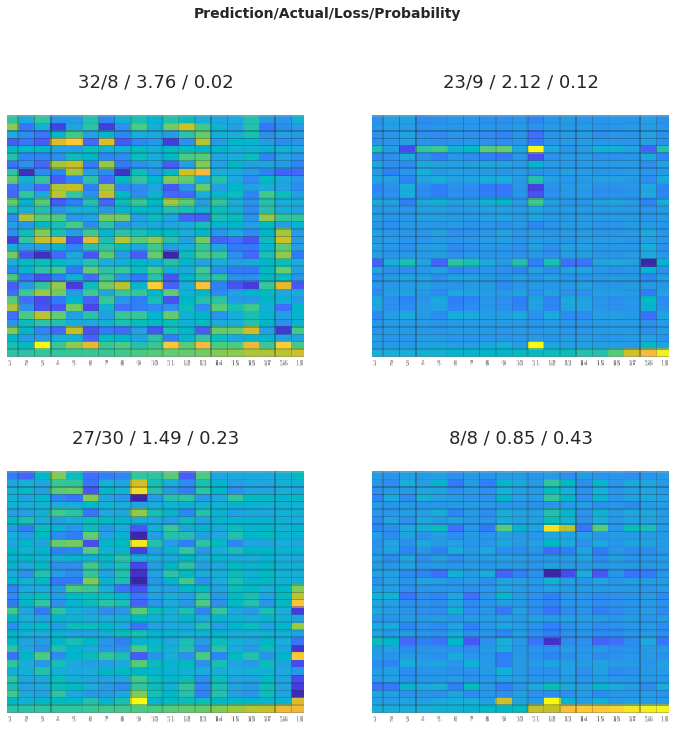

In [127]:
interp.plot_top_losses(4)

In [ ]:
idx=5
x,y = data.valid_ds[idx]
x.show()

In [ ]:
m = learn.model.eval();
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

In [ ]:
def show_heatmap(hm,filename):
    _,ax = plt.subplots(figsize=(20,10))
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.7, extent=(0,200,200,0), #this is werid with resize...
              interpolation='bilinear', cmap='magma');
    plt.savefig(filename)

In [ ]:
# show_heatmap(avg_acts,'test.png')

In [ ]:
# for idx in range(0,200):
#     x,y = src.valid_ds[idx]
#     xb,_ = src.one_item(x)
#     xb_im = Image(src.denorm(xb)[0])
#     xb = xb.cuda()
#     hook_a,hook_g = hooked_backward()
#     acts  = hook_a.stored[0].cpu()
#     avg_acts = acts.mean(0)
#     filename='heatmap_'+str(idx)+'.png'
#     show_heatmap(avg_acts,filename)
    